Переведем data.json в удобный для работы формат.

1.Функции:

read_json - читаем исходный файл и переводим данные в список словарей.
Array_of_unique_ingredients - создаем  массив, состоящий из оригинальных названий ингридиентов.
create_dataframe - создание датафрейма из списка словарей и ингридиентов с применением One Hot Encoder.

In [2]:
import json
import numpy as np
import pandas as pd


def read_json(path: str) -> list:
    with open(path) as f:
        return json.load(f)


def Array_of_unique_ingredients(data: list) -> np.array:
    ret = []
    for obj in data:
        for ing in obj['ingredients']:
            ret.append(ing)
    return np.unique(ret)


def create_dataframe(data: list, unique_ingredients: np.array) -> pd.DataFrame:
    cols = np.append(unique_ingredients, 'cuisine')
    df = pd.DataFrame(index=[_['id'] for _ in data], columns=cols)
    for obj in data:
        id = obj['id']
        df.loc[df.index == id, 'cuisine'] = obj['cuisine']
        for ing in obj['ingredients']:
            df.loc[df.index == id, ing] = True
    return df.fillna(value=False)


def json_to_dataframe(path):
    data = read_json(path)
    unique_ingredients = Array_of_unique_ingredients(data)
    return create_dataframe(data, unique_ingredients)

2.Внешний вид созданного датафрейма.

In [7]:
df = json_to_dataframe("data.json")
df.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms,cuisine
10259,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,greek
25693,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,southern_us
20130,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,filipino
22213,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,indian
13162,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,indian


3.Основная статистика

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 10259 to 2362
Columns: 6715 entries, (    oz.) tomato sauce to cuisine
dtypes: bool(6714), object(1)
memory usage: 255.3+ MB


4.Рассмотрим самые популярные ингридиенты внутри каждой кухни. Для этого создадим массив, который состит из кухонь каждого вида.
Как мы можем заметить, самыми популярными ингридиентами являются: соль , соевый соус и рыбный соус.

In [8]:
cuisines = np.unique(df['cuisine'])
most_popular_ing_by_cuisine = {}
for cuisine in cuisines:
  tmp_dict = {}
  for col in df.columns[:-1]:
    tmp_dict[col] = df[df['cuisine'] == cuisine][col].sum()
  most_popular_ing_by_cuisine[cuisine] = max(tmp_dict, key=tmp_dict.get)
print(most_popular_ing_by_cuisine)

{'brazilian': 'salt', 'british': 'salt', 'cajun_creole': 'salt', 'chinese': 'soy sauce', 'filipino': 'salt', 'french': 'salt', 'greek': 'salt', 'indian': 'salt', 'irish': 'salt', 'italian': 'salt', 'jamaican': 'salt', 'japanese': 'soy sauce', 'korean': 'soy sauce', 'mexican': 'salt', 'moroccan': 'salt', 'russian': 'salt', 'southern_us': 'salt', 'spanish': 'salt', 'thai': 'fish sauce', 'vietnamese': 'fish sauce'}


5.Рассмотрим как часто та или иная кухня встречается в предоставленных данных.

In [ ]:
print(df['cuisine'].value_counts())

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64


6. Визуализируем результаты.

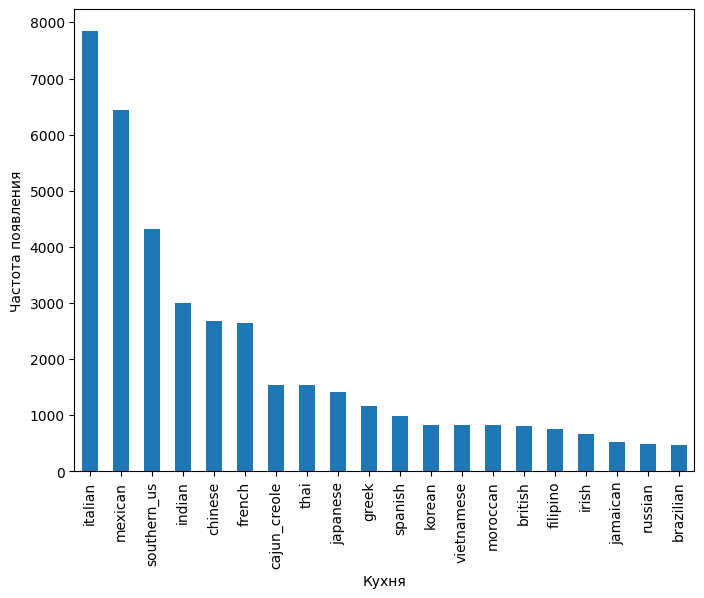

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df['cuisine'].value_counts().plot(kind='bar')
plt.xlabel('Кухня')
plt.ylabel('Частота появления')
plt.show()

7. По вышепредставленной диаграме мы можем сказть что, некоторые кухни встречаются намного чаще остальных. Следовательно, для корректного обучения следует разделить данные на трейн и тест таким образом, чтобы частота вхождения каждого вида кухонь была одинакова в обеих выборках.
Ниже представлена статистика для тренировочной и тестовой выборки.

In [ ]:
df.reset_index(drop=True, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('cuisine', axis=1)
y = df['cuisine']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=1281283)

for train_index, test_index in sss.split(X, y):
  X_train = df.loc[train_index].drop('cuisine', axis=1)
  X_test = df.loc[test_index].drop('cuisine', axis=1)
  y_train = (df.loc[train_index])['cuisine']
  y_test = (df.loc[test_index])['cuisine']


print(y_train.value_counts())
print(y_test.value_counts())

italian         2351
mexican         1931
southern_us     1296
indian           901
chinese          802
french           794
cajun_creole     464
thai             462
japanese         427
greek            352
spanish          297
korean           249
vietnamese       247
moroccan         246
british          241
filipino         227
irish            200
jamaican         158
russian          147
brazilian        140
Name: cuisine, dtype: int64
italian         5487
mexican         4507
southern_us     3024
indian          2102
chinese         1871
french          1852
cajun_creole    1082
thai            1077
japanese         996
greek            823
spanish          692
korean           581
vietnamese       578
moroccan         575
british          563
filipino         528
irish            467
jamaican         368
russian          342
brazilian        327
Name: cuisine, dtype: int64


8.Применим логистическую регрессию.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
lg = LogisticRegression(solver='lbfgs', max_iter=200)
lg.fit(X_train, y_train)
predictions = lg.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7416


9. Данный метод дал не очень приятный результат.
Используем метод Random forest. Может в этом случае значение точности будет больше.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy RF: {accuracy:.4f}")

Accuracy RF: 0.6769


10. Надежды не оправдались. Используем метод градиентного спуска.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Создание модели Gradient Boosting для бинарной классификации
gradient_boosted = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)


# Fit the model on the training data
gradient_boosted.fit(X_train, y_train)

# Make predictions on the test data
predictions = gradient_boosted.predict(X_test)

print(f"Accuracy GB: {accuracy_score(y_test, predictions):.4f}")

Accuracy GB: 0.6798


11. Полученная точность не радует. Попробуем увеличить её значение. Для этого подберем гиперпараметры.

In [ ]:
model = GradientBoostingClassifier()

# Определение сетки гиперпараметров
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Поиск наилучших гиперпараметров
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_



12. К сожалению, результата нет. Слишком долго считал и вылетел.

Заключение:

В ходе обучения было использованно три метода: логистическая регрессия, случайный лес, градиентный спуск. Полученные значения точностей:
логистическая регрессия - 0.7416
градиентный спуск - 0.6798
случайный лес - 0.6769

